In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from sklearn.metrics import confusion_matrix
import os
from Graphs import matrix_to_graph, graph_to_matrix, ErdosRenyiGraph, getLambda
from ShortestDistanceAlgorithms import shortestDistance_allNodes_networkx, shortestDistance_allNodes_Bourgain, shortestDistance_allNodes_Sarma
from Models import build

from itertools import chain

In [2]:
def generateERSamples_inner(num_graphs,n):

    #largest_component_sizes = []
    #lbds = []

    samples_x = []
    samples_y_actual = []
    samples_y_Bourgain = []
    samples_y_Sarma1 = []
    samples_y_Sarma2 = []
    samples_y_Sarma3 = []
    #samples_y_Sarma4 = []
    samples_edge_index = []

    max_lbd = getLambda(n)
    k = 0
    n_rejected1 = 0
    n_rejected2 = 0
    while k < num_graphs:
        try:
            lbd = np.random.uniform(0, max_lbd)
            object,directed,weighted = ErdosRenyiGraph(n,lbd/n)
            components = list(nx.strongly_connected_components(object))
            largest_component = max(components, key=len)
            n_nodes = len(largest_component)
            r = 1
            if n_nodes >= 10:
                #largest_component_sizes.append(n_nodes)
                #lbds.append(lbd)
                object = object.subgraph(largest_component)
                object = nx.relabel_nodes(object, {node: index for index, node in enumerate(object.nodes())})
                matrix = graph_to_matrix(object)
                seeds = np.random.choice(range(n_nodes),size=r,replace=False)
                x = np.zeros((n_nodes,r))
                y_actual = np.zeros((n_nodes,r))
                y_Bourgain = np.zeros((n_nodes,r))
                y_Sarma1 = np.zeros((n_nodes,r))
                y_Sarma2 = np.zeros((n_nodes,r))
                y_Sarma3 = np.zeros((n_nodes,r))
                #y_Sarma4 = np.zeros((n_nodes,r))
                M = n_nodes
                for i in range(r):
                    u = seeds[i]
                    #support = [n for n in range(matrix.shape[0]) if np.count_nonzero(matrix[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
                    #print(support)
                    x[u,i] = 1
                    y_actual[:,i] = shortestDistance_allNodes_networkx(object,u)
                    if n <= 200:
                        y_Bourgain[:,i] = shortestDistance_allNodes_Bourgain(matrix,u)
                        y_Bourgain = np.where(y_Bourgain == float('inf'), M, y_Bourgain)
                        y_Sarma1[:,i] = shortestDistance_allNodes_Sarma(matrix,u,1)
                        y_Sarma1 = np.where(y_Sarma1 == float('inf'), M, y_Sarma1)
                        y_Sarma2[:,i] = shortestDistance_allNodes_Sarma(matrix,u,2)
                        y_Sarma2 = np.where(y_Sarma2 == float('inf'), M, y_Sarma2)
                        y_Sarma3[:,i] = shortestDistance_allNodes_Sarma(matrix,u,3)
                        y_Sarma3 = np.where(y_Sarma3 == float('inf'), M, y_Sarma3)
                    #y_Sarma4[:,i] = shortestDistance_allNodes_Bourgain(matrix,u,4)
                    #y_Sarma4 = np.where(y_Sarma4 == float('inf'), M, y_Sarma4)
                samples_x.append(torch.tensor(x.astype(np.float32), requires_grad=True))
                samples_y_actual.append(torch.tensor(y_actual).to(torch.float32))
                samples_y_Bourgain.append(y_Bourgain)
                samples_y_Sarma1.append(y_Sarma1)
                samples_y_Sarma2.append(y_Sarma2)
                samples_y_Sarma3.append(y_Sarma3)
                #samples_y_Sarma4.append(y_Sarma4)
                samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                k += 1
            else:
                n_rejected2 += 1
        except:
            n_rejected1 += 1
    
    print('Number of graphs rejected because Bourgain\'s and Sarma\'s algorithms yield errors: ',n_rejected1)
    print('Number of graphs rejected because the largest component has insufficient size: ',n_rejected2)

    return samples_x, [samples_y_actual, samples_y_Bourgain, samples_y_Sarma1, samples_y_Sarma2, samples_y_Sarma3], samples_edge_index, None

def generateERSamples(n_train,n_val,n_test,n):
    print('Generating training data...')
    train = generateERSamples_inner(n_train,n)
    print('Generating validation data...')
    val = generateERSamples_inner(n_val,n)
    print('Generating test data...')
    test = generateERSamples_inner(n_test,n)
    return [train, val, test]

In [3]:
def predict(gpu_bool,model,criterion_type,samples_x,samples_edge_index=None,samples_weights=None):
    y_pred = []
    if gpu_bool:
        model = model.to('cuda:1')
    model.eval()
    with torch.no_grad():
        if model.name == 'mlp':
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                else:
                    x = samples_x[i]
                out = model(x)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        elif samples_weights == None:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                out = model(x,edge_index)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        else:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                    weights = samples_weights[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                    weights = samples_weights[i]
                out = model(x,edge_index,weights)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
    model = model.to('cpu')
    return y_pred

def predict_allBatches(model,criterion_type,samples):
    gpu_bool = torch.cuda.is_available()
    y_pred_train = predict(gpu_bool, model, criterion_type, samples[0][0], samples[0][2], samples[0][3])
    y_pred_val = predict(gpu_bool, model, criterion_type, samples[1][0], samples[1][2], samples[1][3])
    y_pred_test = predict(gpu_bool, model, criterion_type, samples[2][0], samples[2][2], samples[2][3])
    return y_pred_train,y_pred_val,y_pred_test

In [4]:
def predict_out1(gpu_bool,model,criterion_type,samples_x,samples_edge_index=None,samples_weights=None):
    y_pred = []
    if gpu_bool:
        model = model.to('cuda:1')
    model.eval()
    with torch.no_grad():
        if model.name == 'mlp':
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                else:
                    x = samples_x[i]
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1))  # Perform a single forward pass.
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)
        elif samples_weights == None:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1),edge_index)  # Perform a single forward pass.
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)
        else:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                    weights = samples_weights[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                    weights = samples_weights[i]
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1),edge_index,weights)  # Perform a single forward pass.
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)
    model = model.to('cpu')
    return y_pred

def predict_out1_allBatches(model,criterion_type,samples):
    gpu_bool = torch.cuda.is_available()
    y_pred_train = predict_out1(gpu_bool, model, criterion_type, samples[0][0], samples[0][2], samples[0][3])
    y_pred_val = predict_out1(gpu_bool, model, criterion_type, samples[1][0], samples[1][2], samples[1][3])
    y_pred_test = predict_out1(gpu_bool, model, criterion_type, samples[2][0], samples[2][2], samples[2][3])
    return y_pred_train,y_pred_val,y_pred_test

In [5]:
def test(gpu_bool,model,criterion,criterion_type,samples_x,samples_y,samples_edge_index = None,samples_weights = None):
    t_loss = 0
    total_samples = 0
    y_pred = []
    model.eval()
    with torch.no_grad():
        if samples_edge_index == None:
            for x,y in list(zip(samples_x,samples_y)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                out = model(x)  # Perform a single forward pass.
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y)
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        elif samples_weights == None:
            for x,y,edge_index in list(zip(samples_x,samples_y,samples_edge_index)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                out = model(x,edge_index)  # Perform a single forward pass.
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y)
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        else:
            for x,y,edge_index,weights in list(zip(samples_x,samples_y,samples_edge_index,samples_weights)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                    weights = weights.to('cuda:1')
                out = model(x,edge_index,weights)  # Perform a single forward pass.
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y)
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())

    t_loss = t_loss.cpu()/total_samples
    if criterion_type in ['mse','l2','l1','mse-mse']:
        return t_loss, None, None, None
    else:
        y_true = np.array([y.cpu() for y in samples_y])
        y_pred = np.array(y_pred)
        t_accuracy = sum(y_true == y_pred)/len(y_true)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        t_sensitivity = tp / (tp + fn)
        t_specificity = tn / (tn + fp)
        return t_loss, t_accuracy, t_sensitivity, t_specificity

def train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val,edge_index_train=None,edge_index_val=None,weights_train=None,weights_val=None):
    model.train()
    if edge_index_train == None:
        for x,y in list(zip(x_train,y_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
            out = model(x)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y)
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    elif weights_train == None:
        for x,y,edge_index in list(zip(x_train,y_train,edge_index_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
            #print(x.shape)
            out = model(x,edge_index)  # Perform a single forward pass
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y)
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    else:
        for x,y,edge_index,weights in list(zip(x_train,y_train,edge_index_train,weights_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
                weights = weights.to('cuda:1')
            out = model(x,edge_index,weights)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y)
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.

    train_loss, train_accuracy, train_sensitivity, train_specificity = test(gpu_bool,model,criterion,criterion_type,x_train,y_train,edge_index_train,weights_train)
    v_loss, v_accuracy, v_sensitivity, v_specificity = test(gpu_bool,model,criterion,criterion_type,x_val,y_val,edge_index_val,weights_val)

    if scheduler_type in ['step','exponential','cyclic','cosine']:
        scheduler[0].step()
    elif scheduler_type == 'reduce_on_plateau': 
        scheduler[0].step(v_loss)
    elif scheduler_type == 'cyclic-cosine':
        scheduler[0].step()
        scheduler[1].step()
    return train_loss,train_accuracy,train_sensitivity,train_specificity,v_loss,v_accuracy,v_sensitivity,v_specificity

In [6]:
def test_out1(gpu_bool,model,criterion,criterion_type,samples_x,samples_y,samples_edge_index = None,samples_weights = None):
    t_loss = 0
    total_samples = 0
    y_pred = []
    model.eval()
    with torch.no_grad():
        if samples_edge_index == None:
            for x,y in list(zip(samples_x,samples_y)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1))  # Perform a single forward pass.
                # if criterion_type in ['bce']:
                #     t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                # elif criterion_type == 'mse-mse':
                #     t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                # elif criterion_type in ['ce','multimargin']:
                #     t_loss += criterion[0](out, y) ## classification
                # else:
                    t_loss += criterion[0](out.squeeze(), y[:,j])
                    total_samples += 1
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1','mse-mse']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)
        elif samples_weights == None:
            for x,y,edge_index in list(zip(samples_x,samples_y,samples_edge_index)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1),edge_index)  # Perform a single forward pass.
                # if criterion_type in ['bce']:
                #     t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                # elif criterion_type == 'mse-mse':
                #     t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                # elif criterion_type in ['ce','multimargin']:
                #     t_loss += criterion[0](out, y) ## classification
                # else:
                    t_loss += criterion[0](out.squeeze(), y[:,j])
                    total_samples += 1
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1','mse-mse']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)
        else:
            for x,y,edge_index,weights in list(zip(samples_x,samples_y,samples_edge_index,samples_weights)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                    weights = weights.to('cuda:1')
                pred_all = []
                for j in range(x.shape[1]):
                    out = model(x[:,j].reshape(len(x[:,j]),1),edge_index,weights)  # Perform a single forward pass.
                # if criterion_type in ['bce']:
                #     t_loss += criterion[0](out, torch.stack((1-y, y)).T)
                # elif criterion_type == 'mse-mse':
                #     t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                # elif criterion_type in ['ce','multimargin']:
                #     t_loss += criterion[0](out, y) ## classification
                # else:
                    t_loss += criterion[0](out.squeeze(), y[:,j])
                    total_samples += 1
                    if criterion_type in ['bce','ce','multimargin']:
                        pred = out.argmax(dim=1) #  Use the class with highest probability.
                    elif criterion_type in ['mse','l2','l1','mse-mse']:
                        pred = out.squeeze()
                    else:
                        pred = torch.round(out.squeeze())
                    pred_all.append(pred.cpu())
                y_pred.append(np.array(pred_all).T)

    t_loss = t_loss.cpu()/total_samples
    if criterion_type in ['mse','l2','l1','mse-mse']:
        return t_loss, None, None, None
    else:
        y_true = np.array([y.cpu() for y in samples_y])
        y_pred = np.array(y_pred)
        t_accuracy = sum(y_true == y_pred)/len(y_true)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        t_sensitivity = tp / (tp + fn)
        t_specificity = tn / (tn + fp)
        return t_loss, t_accuracy, t_sensitivity, t_specificity

def train_out1(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val,edge_index_train=None,edge_index_val=None,weights_train=None,weights_val=None):
    model.train()
    if edge_index_train == None:
        for x,y in list(zip(x_train,y_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
            for j in range(x.shape[1]):
                out = model(x[:,j].reshape(len(x[:,j]),1))  # Perform a single forward pass.
            # if criterion_type in ['bce']:
            #     t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            # elif criterion_type == 'mse-mse':
            #     t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            # elif criterion_type in ['ce','multimargin']:
            #     t_loss = criterion[0](out, y) ## classification
            # else:
                t_loss = criterion[0](out.squeeze(), y[:,j])
                t_loss.backward()  # Derive gradients
                optimizer.step()  # Update parameters based on gradients.
    elif weights_train == None:
        for x,y,edge_index in list(zip(x_train,y_train,edge_index_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
            for j in range(x.shape[1]):
                #print(x[:,j].shape)
                out = model(x[:,j].reshape(len(x[:,j]),1),edge_index)  # Perform a single forward pass
            # if criterion_type in ['bce']:
            #     t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            # elif criterion_type == 'mse-mse':
            #     t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            # elif criterion_type in ['ce','multimargin']:
            #     t_loss = criterion[0](out, y) ## classification
            # else:
                t_loss = criterion[0](out.squeeze(), y[:,j])
                t_loss.backward()  # Derive gradients
                optimizer.step()  # Update parameters based on gradients.
    else:
        for x,y,edge_index,weights in list(zip(x_train,y_train,edge_index_train,weights_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
                weights = weights.to('cuda:1')
            for j in range(x.shape[1]):
                out = model(x[:,j].reshape(len(x[:,j]),1),edge_index,weights)  # Perform a single forward pass.
            # if criterion_type in ['bce']:
            #     t_loss = criterion[0](out, torch.stack((1-y, y)).T)
            # elif criterion_type == 'mse-mse':
            #     t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            # elif criterion_type in ['ce','multimargin']:
            #     t_loss = criterion[0](out, y) ## classification
            # else:
                t_loss = criterion[0](out.squeeze(), y[:,j])
                t_loss.backward()  # Derive gradients
                optimizer.step()  # Update parameters based on gradients.

    train_loss, train_accuracy, train_sensitivity, train_specificity = test_out1(gpu_bool,model,criterion,criterion_type,x_train,y_train,edge_index_train,weights_train)
    v_loss, v_accuracy, v_sensitivity, v_specificity = test_out1(gpu_bool,model,criterion,criterion_type,x_val,y_val,edge_index_val,weights_val)

    if scheduler_type in ['step','exponential','cyclic','cosine']:
        scheduler[0].step()
    elif scheduler_type == 'reduce_on_plateau': 
        scheduler[0].step(v_loss)
    elif scheduler_type == 'cyclic-cosine':
        scheduler[0].step()
        scheduler[1].step()
    return train_loss,train_accuracy,train_sensitivity,train_specificity,v_loss,v_accuracy,v_sensitivity,v_specificity

In [11]:
def evaluate_inner(n,data_name,y,y_pred):

    y_pred = np.array(list(chain(*[np.ravel(arr) for arr in y_pred])))
    y_actual = np.array(list(chain(*[np.ravel(arr) for arr in y[0]])))
    diff_pred = y_actual - y_pred

    values, base = np.histogram(diff_pred, bins=100)
    cumulative = np.cumsum(values)
    plt.plot(base[:-1], cumulative, label='GNN', alpha = 0.75)

    if n <= 200:

        y_Bourgain = np.array(list(chain(*[np.ravel(arr) for arr in y[1]])))
        y_Sarma1 = np.array(list(chain(*[np.ravel(arr) for arr in y[2]])))
        y_Sarma2 = np.array(list(chain(*[np.ravel(arr) for arr in y[3]])))
        y_Sarma3 = np.array(list(chain(*[np.ravel(arr) for arr in y[4]])))
        diff_Bourgain = y_actual-y_Bourgain
        diff_Sarma1 = y_actual-y_Sarma1
        diff_Sarma2 = y_actual-y_Sarma2
        diff_Sarma3 = y_actual-y_Sarma3

        values, base = np.histogram(diff_Bourgain, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Bourgain', alpha = 0.75)

        values, base = np.histogram(diff_Sarma1, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k=1', alpha = 0.75)

        values, base = np.histogram(diff_Sarma2, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k=2', alpha = 0.75)

        values, base = np.histogram(diff_Sarma3, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='Sarma, k=3', alpha = 0.75)

    plt.xlabel("y_actual - y_pred")
    plt.ylabel("Cummulative Frequency")
    plt.title(data_name+", n = "+str(n))
    plt.legend()
    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
    plt.show()
    
def evaluate(n,model,criterion_type,samples):
    y_pred_train,y_pred_val,y_pred_test = predict_allBatches(model,criterion_type,samples)
    evaluate_inner(n,'Training Data',samples[0][1],y_pred_train)
    evaluate_inner(n,'Validation Data',samples[1][1],y_pred_val)
    evaluate_inner(n,'Test Data',samples[2][1],y_pred_test)

In [8]:
def run(samples,model,criterion_type,optimizer_type,scheduler_type,num_epochs=100,early_stopping_patience=None,save_model = False):

    title = 'out_channels = 1'
    gpu_bool = torch.cuda.is_available()

    x_train = samples[0][0]
    x_val = samples[1][0]
    x_test = samples[2][0]
    y_train = samples[0][1][0]
    y_val = samples[1][1][0]
    y_test = samples[2][1][0]
    edge_index_train = samples[0][2]
    edge_index_val = samples[1][2]
    edge_index_test = samples[2][2]
    weights_train = samples[0][3]
    weights_val = samples[1][3]
    weights_test = samples[2][3]

    in_channels = x_train[0].shape[1]
    out_channels = y_train[0].shape[1]
    if isinstance(model, str):
        model_type = model
        model,criterion,optimizer,scheduler = build(in_channels, out_channels, model_type,criterion_type,optimizer_type,scheduler_type)
    else:
        model_type = model.name
        _,criterion,optimizer,scheduler = build(in_channels, out_channels, model, criterion_type,optimizer_type,scheduler_type)
    print(model)

    if gpu_bool:
        model = model.to('cuda:1')

    train_loss = []
    train_acc = []
    train_sen = []
    train_spec = []
    val_loss = []
    val_acc = []
    val_sen = []
    val_spec = []

    if early_stopping_patience != None:
        best_val_loss = float('inf')
        best_epoch = 0
        no_improvement_count = 0

    for epoch in range(1, num_epochs+1):
        if model_type == 'mlp':
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val)
        else:
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,optimizer_type,x_train,x_val,y_train,y_val,edge_index_train,edge_index_val,weights_train,weights_val)
        train_loss.append(t_loss)
        train_acc.append(t_acc)
        train_sen.append(t_sen)
        train_spec.append(t_spec)
        val_loss.append(v_loss)
        val_acc.append(v_acc)
        val_sen.append(v_sen)
        val_spec.append(v_spec)
        if epoch % 10 == 0:
            if criterion_type in ['mse','l2','mse-mse']:
                print(f'Epoch: {epoch:03d}, Training Loss (MSE): {t_loss:.4f}, Validation Loss (MSE): {v_loss:.4f}')
            elif criterion_type == 'l1':
                print(f'Epoch: {epoch:03d}, Training Loss (MAE): {t_loss:.4f}, Validation Loss (MAE): {v_loss:.4f}')
            else:
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training Accuracy: {t_acc:.4f}, Training Sensitivity: {t_sen:.4f}, Training Specificity: {t_spec:.4f}, Validation Loss: {v_loss:.4f}, Validation Accuracy: {v_acc:.4f}, Validation Sensitivity: {v_sen:.4f}, Validation Specificity: {v_spec:.4f}')

        if early_stopping_patience != None:
            if v_loss < best_val_loss:
                best_val_loss = v_loss
                best_epoch = epoch
                no_improvement_count = 0
                torch.save(model.state_dict(), 'best_model_1.pth')
            else:
                no_improvement_count += 1
            if no_improvement_count >= early_stopping_patience:
                model.load_state_dict(torch.load('best_model_1.pth'))
                if gpu_bool:
                    model = model.to('cuda:1')
                break

    if model_type == 'mlp':
        test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test)
    else:
        test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test, edge_index_test, weights_test)
    
    if early_stopping_patience == None:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')
    else:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')

    x = range(1, len(train_loss)+1)
    plt.plot(x, train_loss, color = '#1f77b4', label = 'Training Loss', alpha = 0.75)
    plt.plot(x, val_loss, color = '#ff7f0e', label = 'Validation Loss', alpha = 0.75)
    if criterion_type in ['ce','bce','bcelogits','multimargin']:
        plt.plot(x, train_acc, color = '#2ca02c', label = 'Training Accuracy', alpha = 0.75)
        plt.plot(x, val_acc, color = '#d62728', label = 'Validation Accuracy', alpha = 0.75)
        plt.plot(x, train_sen, color = '#9467bd', label = 'Training Sensitivity', alpha = 0.75)
        plt.plot(x, val_sen, color = '#8c564b', label = 'Validation Sensitivity', alpha = 0.75)
        plt.plot(x, train_spec, color = '#e377c2', label = 'Training Specificity', alpha = 0.75)
        plt.plot(x, val_spec, color = '#7f7f7f', label = 'Validation Specificity', alpha = 0.75)
    plt.xlabel("Epoch")
    plt.ylabel("")
    plt.title("Training Results: "+title)
    plt.legend()
    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   
    plt.show()

    model = model.to('cpu')
    if save_model:
        torch.save(model.state_dict(), 'trained_model_'+str(model.in_channels)+'_'+str(model.first_hidden_channels)+'_'+str(model.out_channels)+'_'+str(model.n_hidden_layers)+'.pth')

    return model

In [9]:
dir = 'outputs/dump3'

10
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  4794
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  424
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  411
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 010, Training Loss (MSE): 1.8455, Validation Loss (MSE): 2.1638
Epoch: 020, Training Loss (MSE): 1.7845, Validation Loss (MSE): 2.0838
Epoch: 030, Training Loss (MSE): 1.7809, Validation Loss (MSE): 2.0812
Epoch: 040, Training Loss (MSE): 1.7611, Validation Loss (MSE): 2.0537
Epoch: 050, Training Loss (MSE): 1.7663, Validation Loss (MSE): 2.0571
Best Epoch: 046, Test Loss (MSE): 1.875256


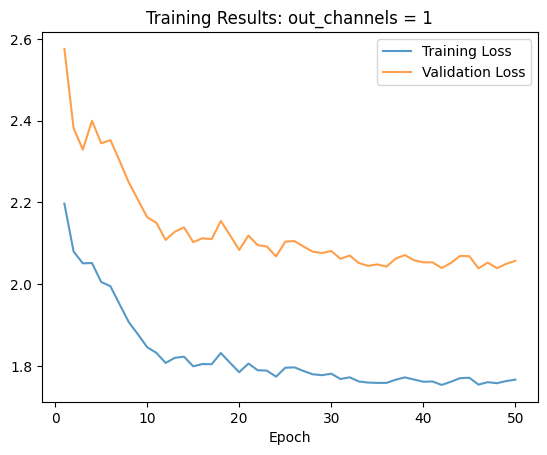

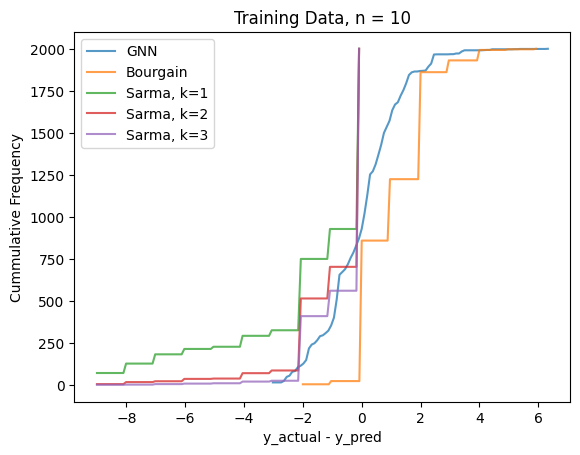

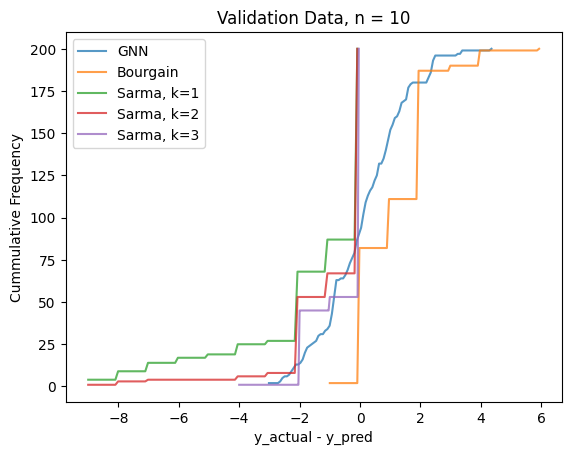

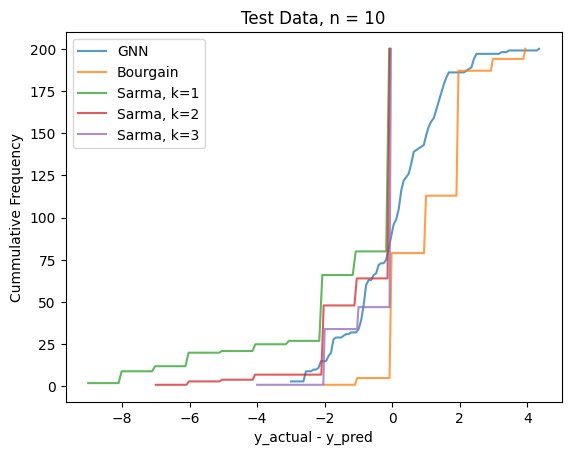

20
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  390
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  35
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  49
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14, 1])) that is different to the input size (torch.Size([14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([11, 1])) that is different to the input size (torch.Size([11])). This will likely lead to incorrect results due to broadcasting. Please ensure 

Epoch: 010, Training Loss (MSE): 3.3852, Validation Loss (MSE): 2.9909
Epoch: 020, Training Loss (MSE): 3.2444, Validation Loss (MSE): 2.9330
Epoch: 030, Training Loss (MSE): 3.1588, Validation Loss (MSE): 2.8628
Epoch: 040, Training Loss (MSE): 3.1566, Validation Loss (MSE): 2.8609
Epoch: 050, Training Loss (MSE): 3.1126, Validation Loss (MSE): 2.8440
Best Epoch: 048, Test Loss (MSE): 2.891356


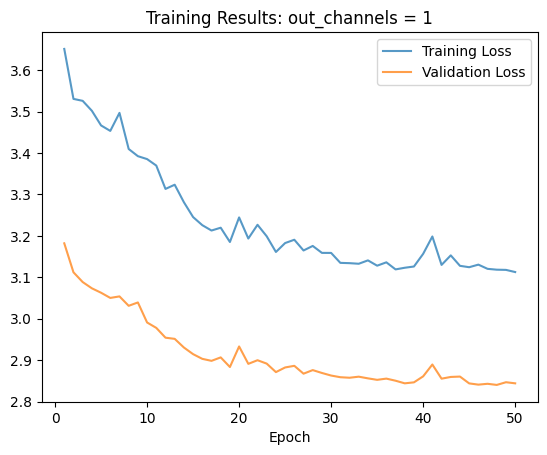

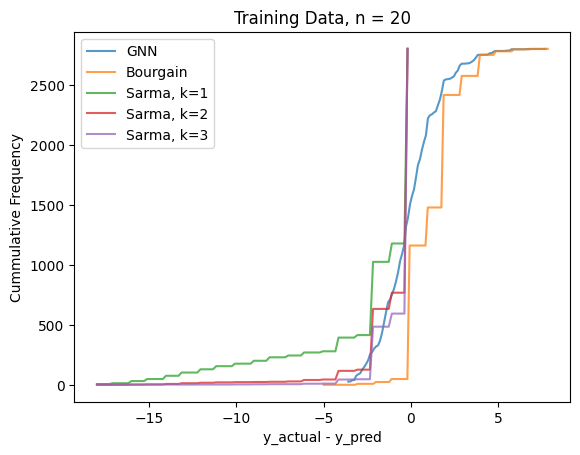

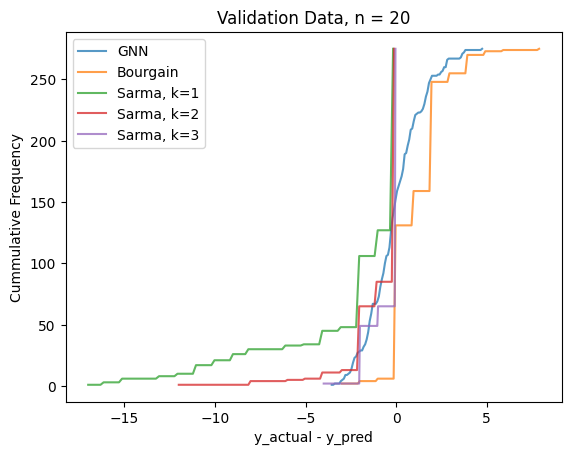

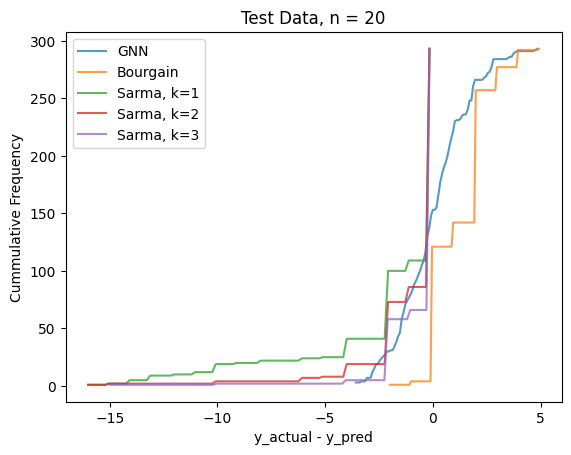

40
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  106
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  8
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  13
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([33, 1])) that is different to the input size (torch.Size([33])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([38, 1])) that is different to the input size (torch.Size([38])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29, 1])) that is different to the input size (torch.Size([29])). This will likely lead to incorrect results due to broadcasting. Please ensure 

Epoch: 010, Training Loss (MSE): 4.2895, Validation Loss (MSE): 3.0340
Epoch: 020, Training Loss (MSE): 4.1638, Validation Loss (MSE): 2.9293
Epoch: 030, Training Loss (MSE): 4.0809, Validation Loss (MSE): 2.8829
Epoch: 040, Training Loss (MSE): 4.0478, Validation Loss (MSE): 2.8743
Best Epoch: 036, Test Loss (MSE): 4.512943


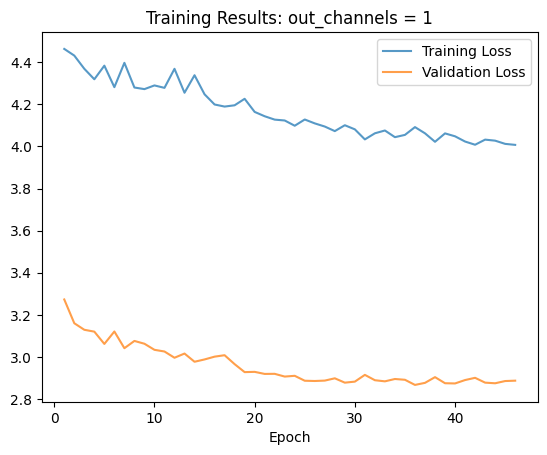

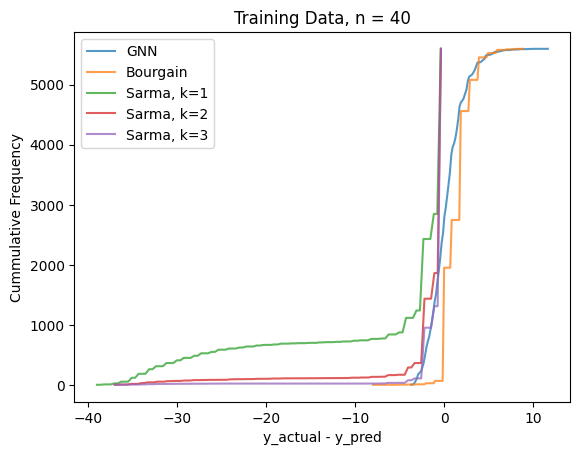

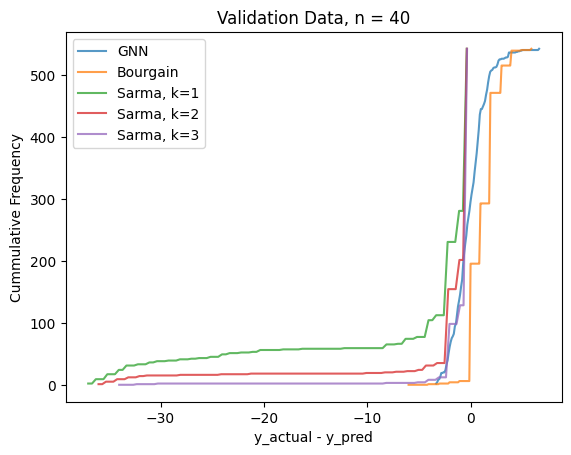

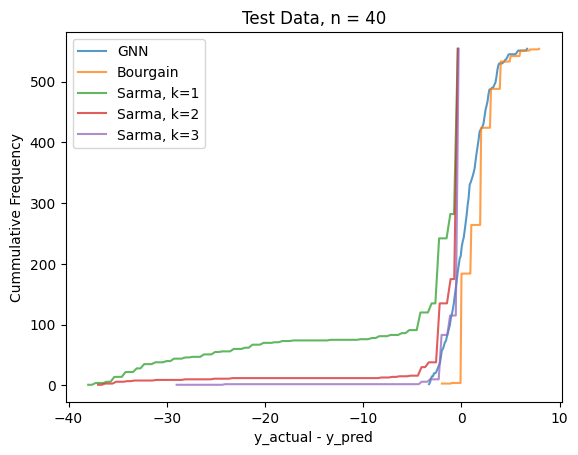

80
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  66
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  7
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  4
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([46, 1])) that is different to the input size (torch.Size([46])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([71, 1])) that is different to the input size (torch.Size([71])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([72, 1])) that is different to the input size (torch.Size([72])). This will likely lead to incorrect results due to broadcasting. Please ensure 

Epoch: 010, Training Loss (MSE): 7.0494, Validation Loss (MSE): 6.3770
Epoch: 020, Training Loss (MSE): 6.7003, Validation Loss (MSE): 6.0490
Epoch: 030, Training Loss (MSE): 6.5445, Validation Loss (MSE): 5.8900
Epoch: 040, Training Loss (MSE): 6.4578, Validation Loss (MSE): 5.8114
Epoch: 050, Training Loss (MSE): 6.4323, Validation Loss (MSE): 5.7822
Best Epoch: 050, Test Loss (MSE): 6.579049


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([48, 1])) that is different to the input size (torch.Size([48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


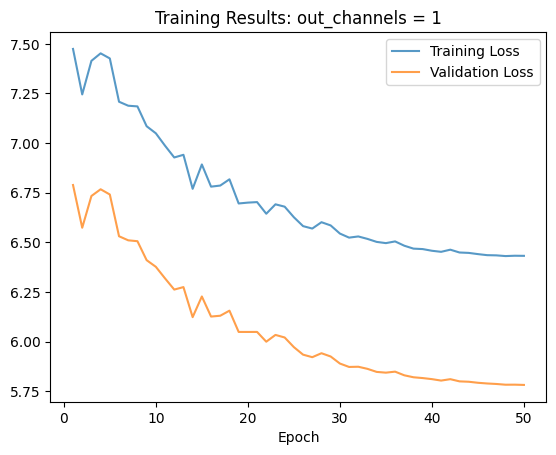

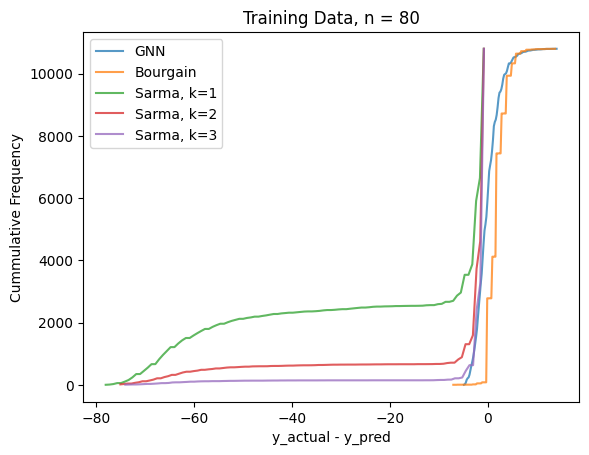

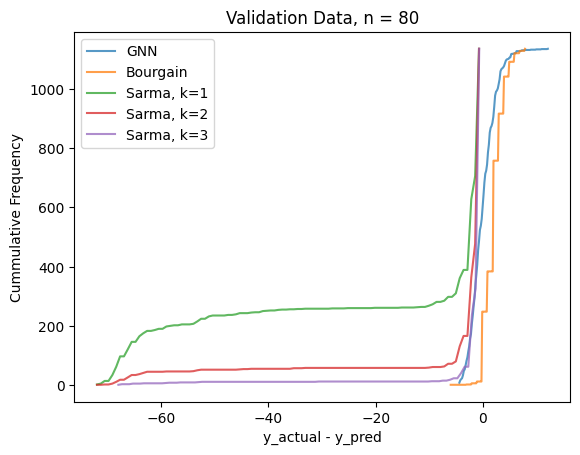

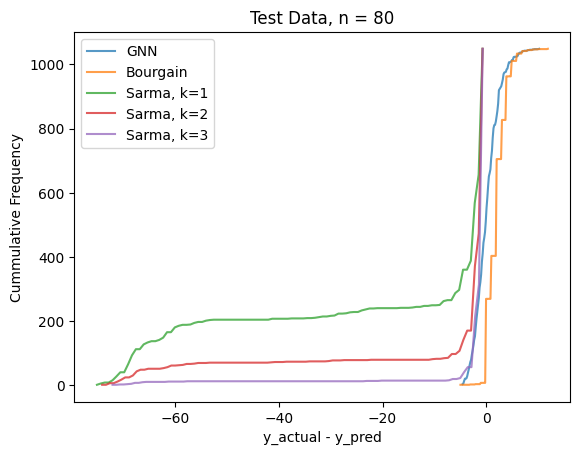

160
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  66
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  8
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  2
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([156, 1])) that is different to the input size (torch.Size([156])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([137, 1])) that is different to the input size (torch.Size([137])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([87, 1])) that is different to the input size (torch.Size([87])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch: 010, Training Loss (MSE): 10.8137, Validation Loss (MSE): 9.0601
Epoch: 020, Training Loss (MSE): 10.5363, Validation Loss (MSE): 8.9457
Epoch: 030, Training Loss (MSE): 10.3476, Validation Loss (MSE): 8.8055
Epoch: 040, Training Loss (MSE): 10.2453, Validation Loss (MSE): 8.6792
Epoch: 050, Training Loss (MSE): 10.1378, Validation Loss (MSE): 8.6881
Best Epoch: 044, Test Loss (MSE): 12.366423


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([84, 1])) that is different to the input size (torch.Size([84])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


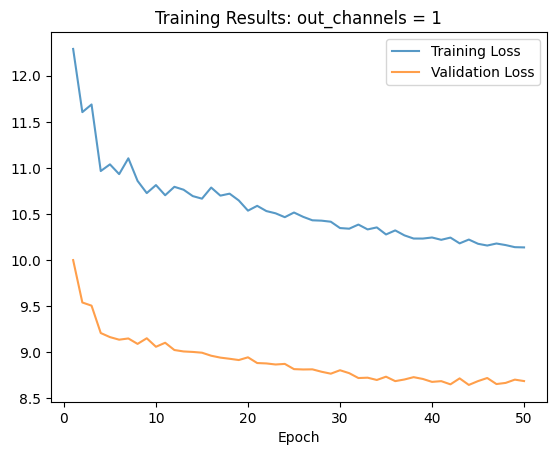

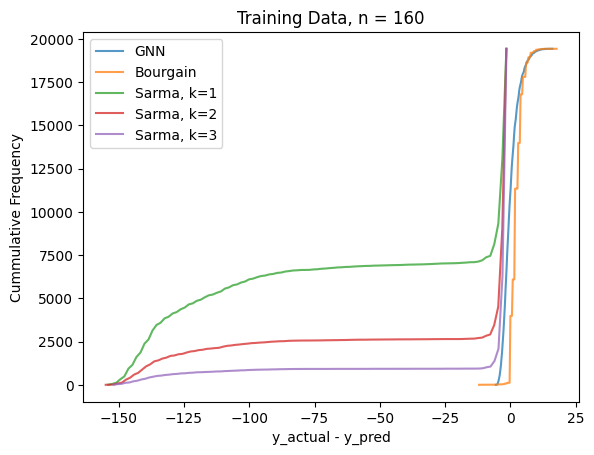

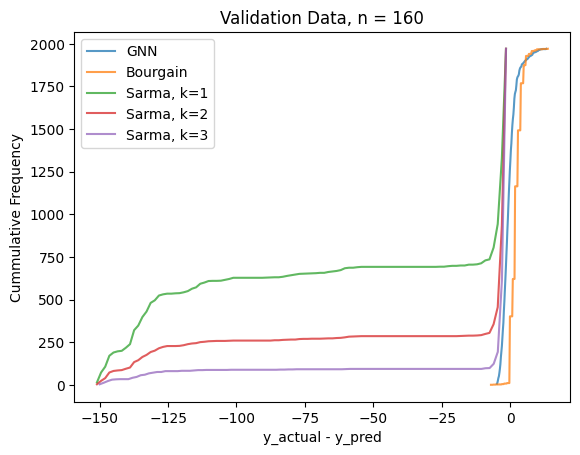

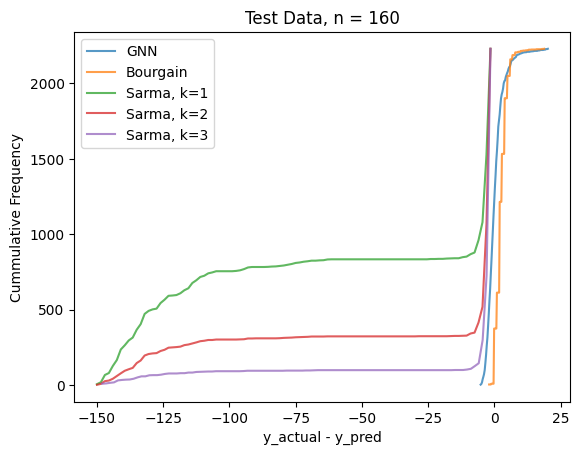

320
Generating training data...


In [10]:
for n in [10,20,40,80,160,320,640]:
    print(n)
    samples = generateERSamples(200,20,20,n)
    model = run(samples,'gcn','mse','adam','cyclic-cosine',50,10)
    evaluate(n,model,'mse',samples)

640
Generating training data...


Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  37
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  6
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  4
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([612, 1])) that is different to the input size (torch.Size([612])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([327, 1])) that is different to the input size (torch.Size([327])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch: 010, Training Loss (MSE): 15.6188, Validation Loss (MSE): 10.5661
Epoch: 020, Training Loss (MSE): 15.4920, Validation Loss (MSE): 10.3366
Epoch: 030, Training Loss (MSE): 15.1736, Validation Loss (MSE): 10.2425
Epoch: 040, Training Loss (MSE): 15.1779, Validation Loss (MSE): 10.1038
Epoch: 050, Training Loss (MSE): 15.0274, Validation Loss (MSE): 10.0056
Best Epoch: 050, Test Loss (MSE): 29.912155


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([479, 1])) that is different to the input size (torch.Size([479])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([211, 1])) that is different to the input size (torch.Size([211])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([425, 1])) that is different to the input size (torch.Size([425])). This will likely lead to incorrect results due to broadcasting. Please e

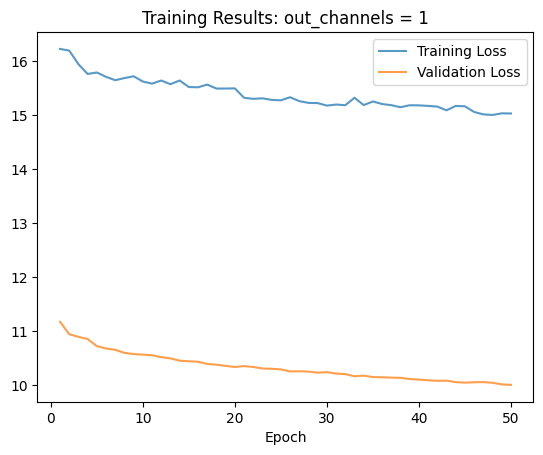

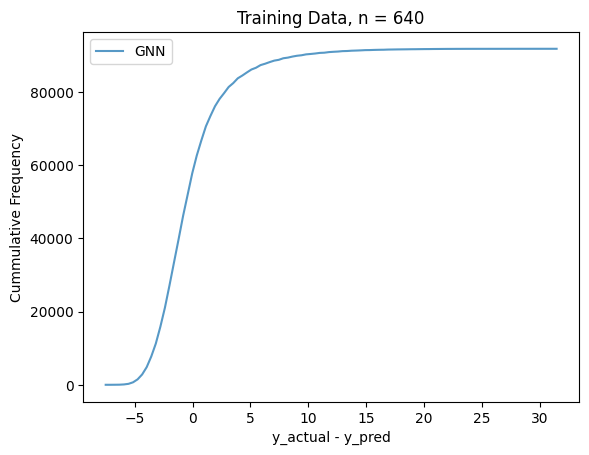

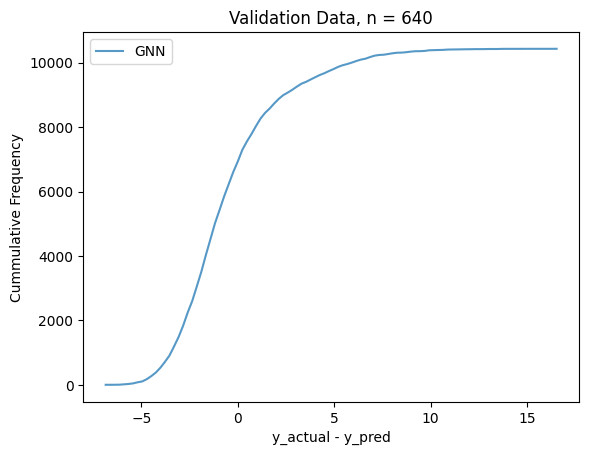

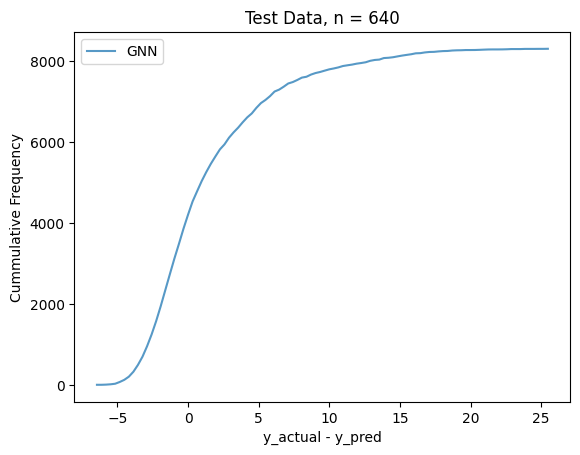

1280
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  29
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  2
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  7
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1166, 1])) that is different to the input size (torch.Size([1166])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([480, 1])) that is different to the input size (torch.Size([480])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([748, 1])) that is different to the input size (torch.Size([748])). This will likely lead to incorrect results due to broadcasting. Please

Epoch: 010, Training Loss (MSE): 27.7598, Validation Loss (MSE): 24.9806
Epoch: 020, Training Loss (MSE): 27.3331, Validation Loss (MSE): 24.6596
Epoch: 030, Training Loss (MSE): 26.9575, Validation Loss (MSE): 24.4273
Epoch: 040, Training Loss (MSE): 26.6727, Validation Loss (MSE): 24.2687
Epoch: 050, Training Loss (MSE): 26.4743, Validation Loss (MSE): 24.1171
Best Epoch: 048, Test Loss (MSE): 14.052414


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1046, 1])) that is different to the input size (torch.Size([1046])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([974, 1])) that is different to the input size (torch.Size([974])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([791, 1])) that is different to the input size (torch.Size([791])). This will likely lead to incorrect results due to broadcasting. Please

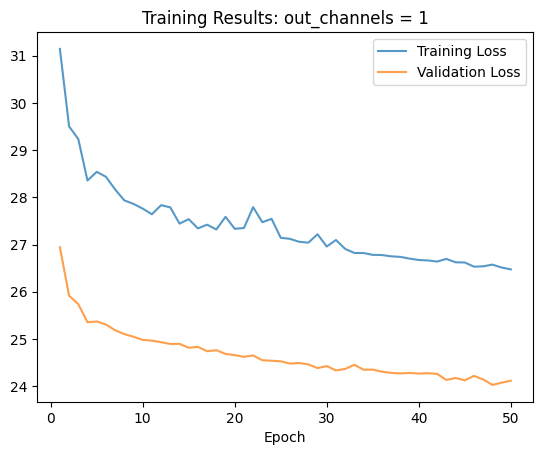

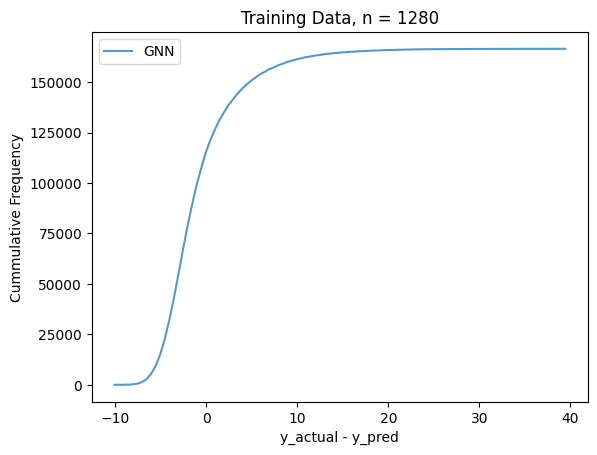

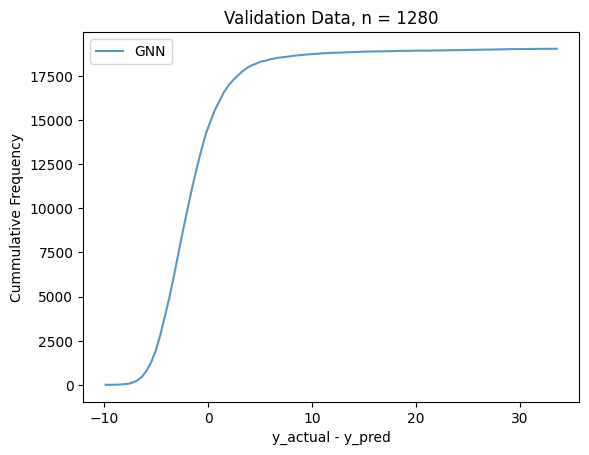

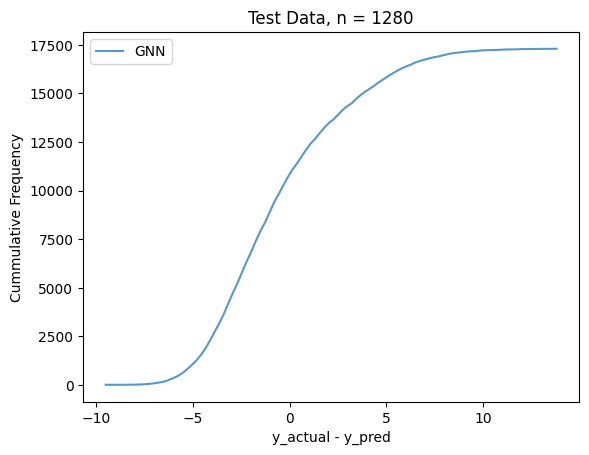

In [12]:
for n in [640,1280]:
    print(n)
    samples = generateERSamples(200,20,20,n)
    model = run(samples,'gcn','mse','adam','cyclic-cosine',50,10)
    evaluate(n,model,'mse',samples)

2560
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  21
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  4
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  2
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2405, 1])) that is different to the input size (torch.Size([2405])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2148, 1])) that is different to the input size (torch.Size([2148])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1887, 1])) that is different to the input size (torch.Size([1887])). This will likely lead to incorrect results due to broadcasting. Pl

Epoch: 010, Training Loss (MSE): 35.6693, Validation Loss (MSE): 52.9814
Epoch: 020, Training Loss (MSE): 35.4595, Validation Loss (MSE): 52.9605
Epoch: 030, Training Loss (MSE): 35.2481, Validation Loss (MSE): 52.6941
Best Epoch: 028, Test Loss (MSE): 58.093544


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([732, 1])) that is different to the input size (torch.Size([732])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1174, 1])) that is different to the input size (torch.Size([1174])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2321, 1])) that is different to the input size (torch.Size([2321])). This will likely lead to incorrect results due to broadcasting. Plea

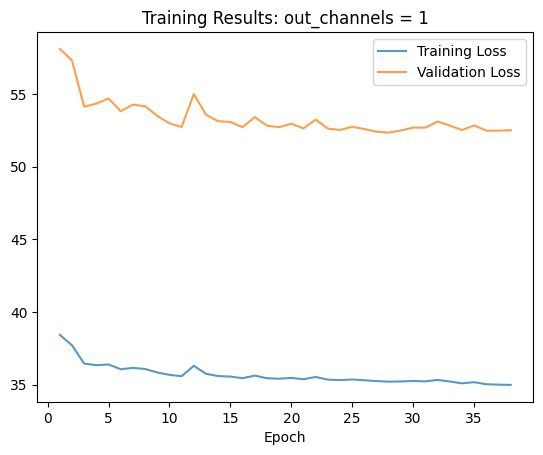

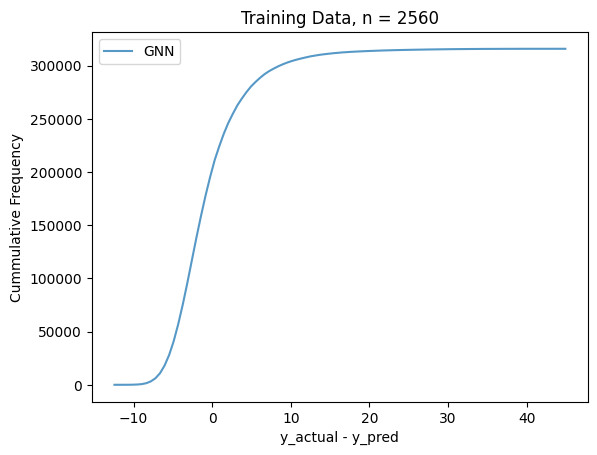

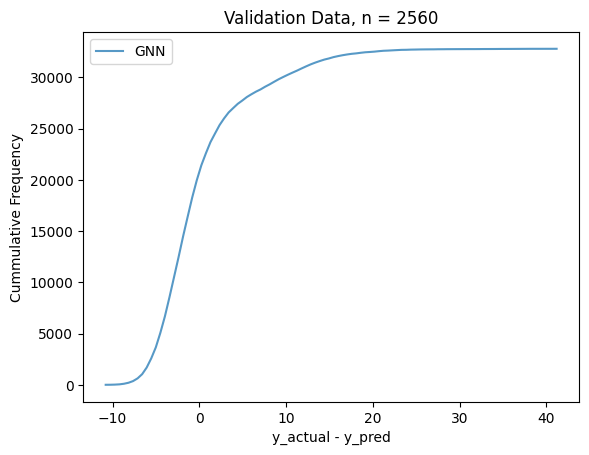

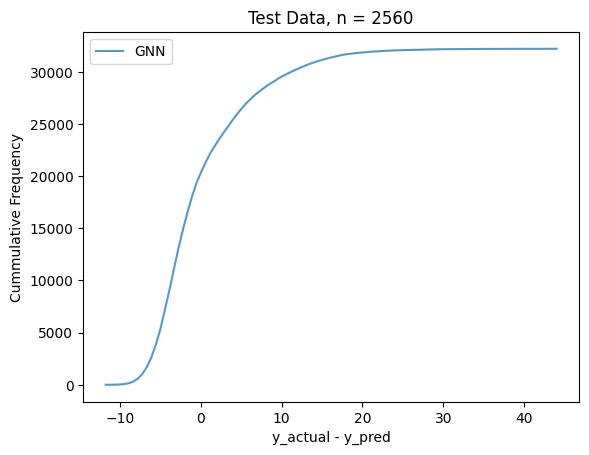

5120
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  14
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  0
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4289, 1])) that is different to the input size (torch.Size([4289])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5039, 1])) that is different to the input size (torch.Size([5039])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5085, 1])) that is different to the input size (torch.Size([5085])). This will likely lead to incorrect results due to broadcasting. Pl

Epoch: 010, Training Loss (MSE): 52.1435, Validation Loss (MSE): 23.0938
Epoch: 020, Training Loss (MSE): 51.7317, Validation Loss (MSE): 23.2254
Best Epoch: 011, Test Loss (MSE): 122.137001


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3077, 1])) that is different to the input size (torch.Size([3077])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([605, 1])) that is different to the input size (torch.Size([605])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2154, 1])) that is different to the input size (torch.Size([2154])). This will likely lead to incorrect results due to broadcasting. Plea

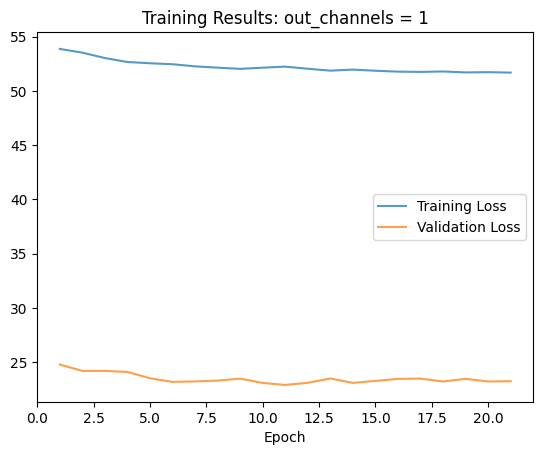

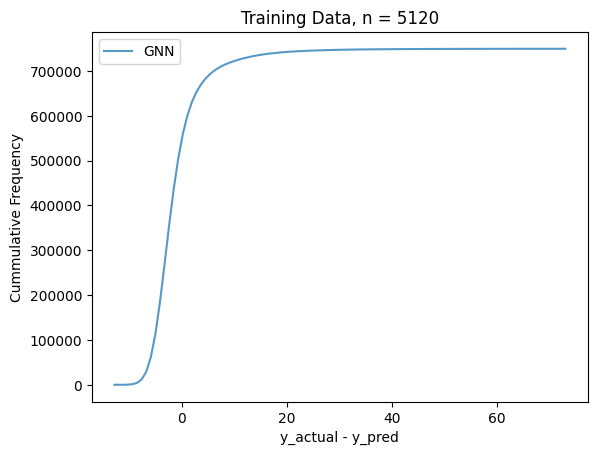

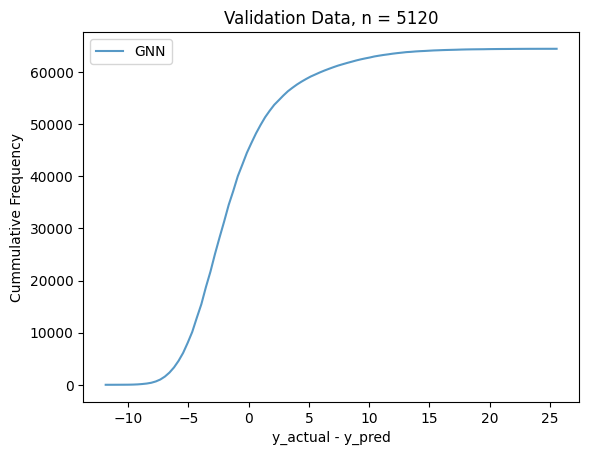

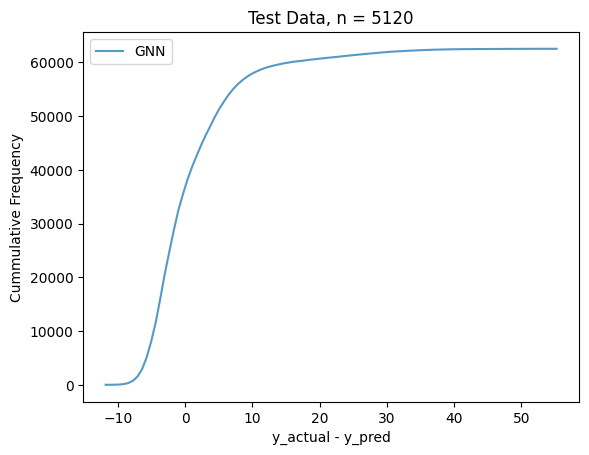

10240
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  10
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  4
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  4
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10132, 1])) that is different to the input size (torch.Size([10132])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9489, 1])) that is different to the input size (torch.Size([9489])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([724, 1])) that is different to the input size (torch.Size([724])). This will likely lead to incorrect results due to broadcasting. Pl

Epoch: 010, Training Loss (MSE): 63.8151, Validation Loss (MSE): 13.7373
Best Epoch: 001, Test Loss (MSE): 72.221779


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6245, 1])) that is different to the input size (torch.Size([6245])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9944, 1])) that is different to the input size (torch.Size([9944])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9603, 1])) that is different to the input size (torch.Size([9603])). This will likely lead to incorrect results due to broadcasting. Pl

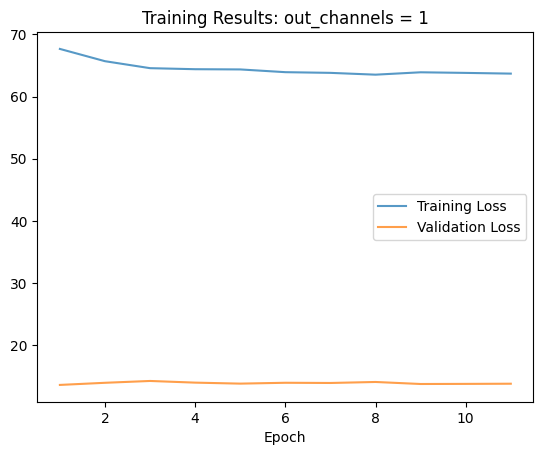

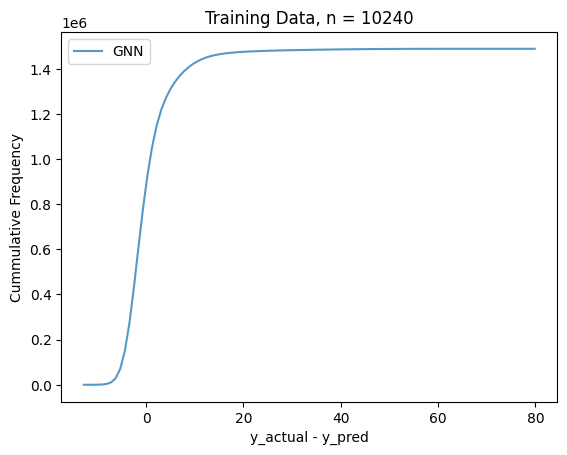

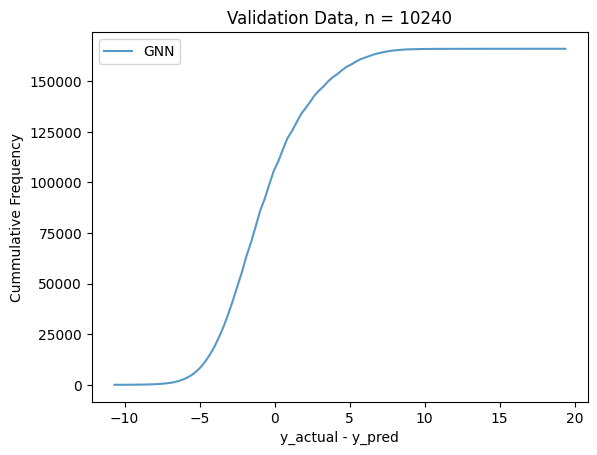

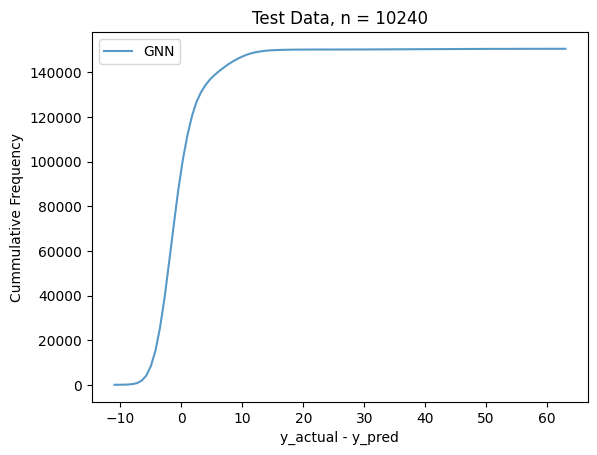

20480
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  13
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  2
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  1
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([19472, 1])) that is different to the input size (torch.Size([19472])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15220, 1])) that is different to the input size (torch.Size([15220])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18589, 1])) that is different to the input size (torch.Size([18589])). This will likely lead to incorrect results due to broadcasti

Epoch: 010, Training Loss (MSE): 72.6925, Validation Loss (MSE): 62.9959
Epoch: 020, Training Loss (MSE): 72.2603, Validation Loss (MSE): 62.7985
Epoch: 030, Training Loss (MSE): 71.6271, Validation Loss (MSE): 62.4086
Epoch: 040, Training Loss (MSE): 71.2757, Validation Loss (MSE): 62.1222
Epoch: 050, Training Loss (MSE): 71.1975, Validation Loss (MSE): 62.0443
Best Epoch: 048, Test Loss (MSE): 123.522476


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4213, 1])) that is different to the input size (torch.Size([4213])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([19713, 1])) that is different to the input size (torch.Size([19713])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18796, 1])) that is different to the input size (torch.Size([18796])). This will likely lead to incorrect results due to broadcasting

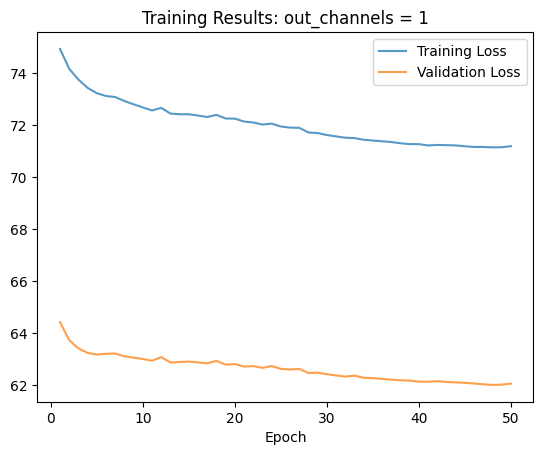

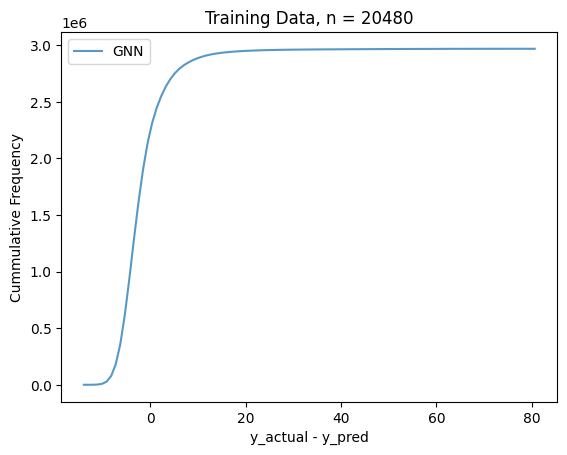

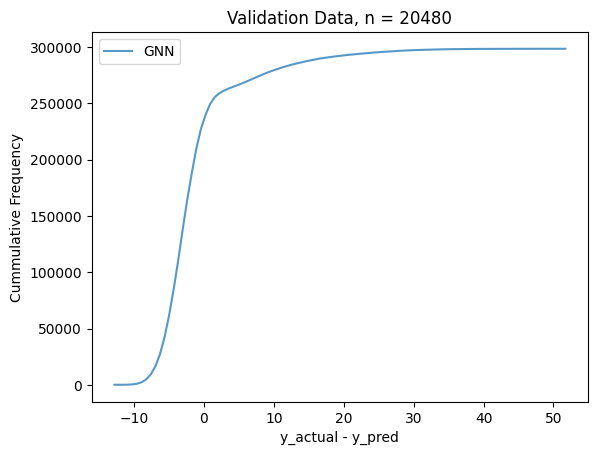

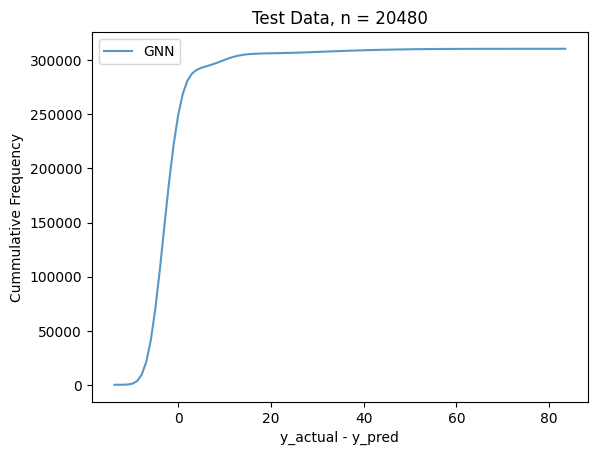

40960
Generating training data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  15
Generating validation data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  1
Generating test data...
Number of graphs rejected because Bourgain's and Sarma's algorithms yield errors:  0
Number of graphs rejected because the largest component has insufficient size:  2
GCN(
  (conv1): GCNConv(1, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 8)
  (conv5): GCNConv(8, 1)
  (reLU): ReLU()
)


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29969, 1])) that is different to the input size (torch.Size([29969])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40558, 1])) that is different to the input size (torch.Size([40558])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9522, 1])) that is different to the input size (torch.Size([9522])). This will likely lead to incorrect results due to broadcasting

Epoch: 010, Training Loss (MSE): 107.3444, Validation Loss (MSE): 55.5988
Epoch: 020, Training Loss (MSE): 105.8144, Validation Loss (MSE): 54.6679
Epoch: 030, Training Loss (MSE): 104.7470, Validation Loss (MSE): 53.8937
Epoch: 040, Training Loss (MSE): 104.6071, Validation Loss (MSE): 53.8049
Epoch: 050, Training Loss (MSE): 105.3892, Validation Loss (MSE): 54.2604


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40654, 1])) that is different to the input size (torch.Size([40654])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37903, 1])) that is different to the input size (torch.Size([37903])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([34332, 1])) that is different to the input size (torch.Size([34332])). This will likely lead to incorrect results due to broadcasti

Best Epoch: 040, Test Loss (MSE): 41.487289


/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40217, 1])) that is different to the input size (torch.Size([40217])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([35046, 1])) that is different to the input size (torch.Size([35046])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/myl/envs/shortestpath/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40482, 1])) that is different to the input size (torch.Size([40482])). This will likely lead to incorrect results due to broadcasti

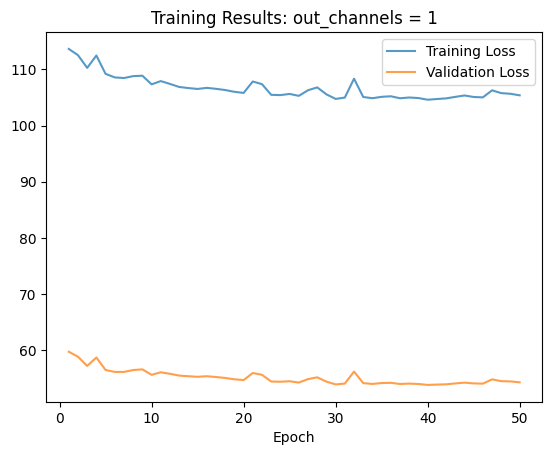

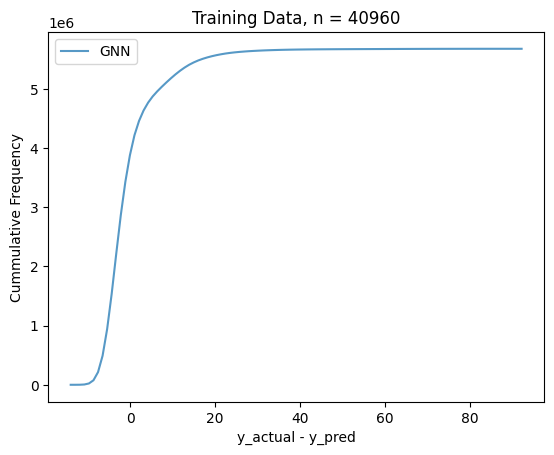

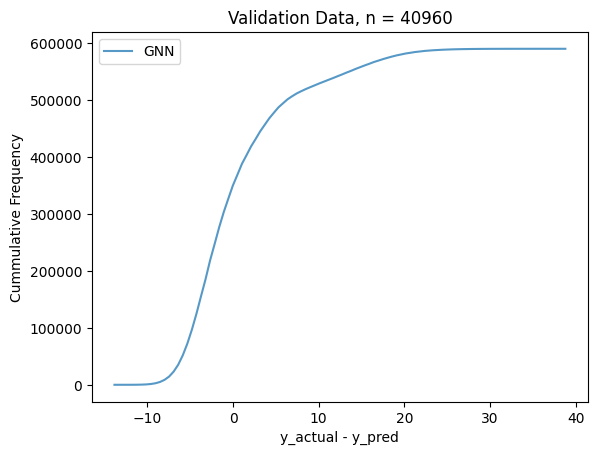

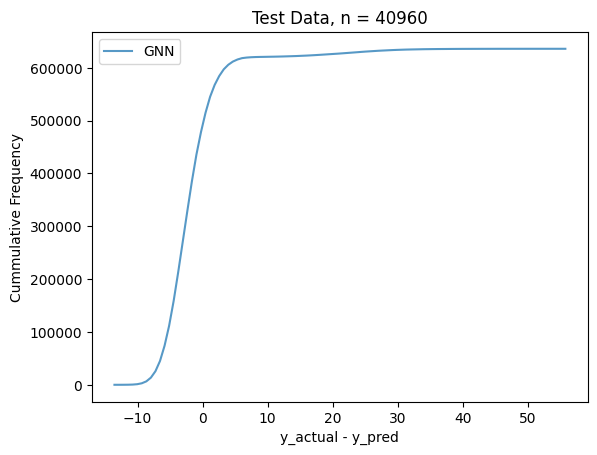

In [15]:
for n in [1280*2,1280*4,1280*8,1280*16,1280*32]:
    print(n)
    samples = generateERSamples(200,20,20,n)
    model = run(samples,'gcn','mse','adam','cyclic-cosine',50,10)
    evaluate(n,model,'mse',samples)